In [1]:
import re
import jieba
import gensim
import numpy as np
from gensim import corpora, models, similarities
from gensim.models import KeyedVectors
from pprint import pprint
from collections import defaultdict
from tqdm import tqdm

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
def load_stopwords(stopwords_path):
    with open(stopwords_path, 'r', encoding='utf-8') as f:
        return [line.strip() for line in f]
    
def preprocess_data(corpus_path, stopwords):
    #clean data
    corpus = []
    with open(corpus_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            line = re.sub(r"[0-9\s+\.\!\/_,$%^*()?;；:-【】+\"\']+|[+——！，;:。？、~@#￥%……&*（）]+", " ", line)
            corpus.append(' '.join([word for word in jieba.lcut(line) if word != " " and word != "\t" and word not in stopwords]))
    return corpus

def cut_low_freq_word(documents, thre):
    #return list of words
    texts = [[word for word in document.split()] for document in documents]
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1
    return [[token for token in text if frequency[token] > thre] for text in texts]

def cut_low_freq_word2(documents, thre):
    #return strings of words seperated by " "
    texts = [[word for word in document.split()] for document in documents]
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1
    return [(" ").join([token for token in text if frequency[token] > thre]) for text in texts]

In [3]:
stopwords_path = "./data/stop_words.txt"
doc_title_east = "./data/company/title_east.txt"
doc_title_apple= "./data/company/title_apple.txt"

In [4]:
stopwords = load_stopwords(stopwords_path)
corp_title_east = preprocess_data(doc_title_east, stopwords)
corp_title_apple = preprocess_data(doc_title_apple, stopwords)

Building prefix dict from the default dictionary ...
2020-07-30 09:25:34,561 : DEBUG : Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/m3/4yh806w92fdgcn0bk16ql7nw0000gn/T/jieba.cache
2020-07-30 09:25:35,312 : DEBUG : Dumping model to file cache /var/folders/m3/4yh806w92fdgcn0bk16ql7nw0000gn/T/jieba.cache
Loading model cost 0.808 seconds.
2020-07-30 09:25:35,370 : DEBUG : Loading model cost 0.808 seconds.
Prefix dict has been built successfully.
2020-07-30 09:25:35,371 : DEBUG : Prefix dict has been built successfully.


In [5]:
texts_title_east = cut_low_freq_word(corp_title_east, 0)
texts_title_apple = cut_low_freq_word(corp_title_apple, 0)

In [6]:
#word2vec model transfer learning on our corpus
model_w2v = gensim.models.Word2Vec(texts_title_east, size=300)
model_w2v.intersect_word2vec_format('./data/sgns.financial.char.bz2',
                                lockf=1.0,
                                encoding='utf8',
                                )
model_w2v.train(texts_title_east,total_examples=model_w2v.corpus_count, epochs=10)

2020-07-30 09:25:55,042 : INFO : collecting all words and their counts
2020-07-30 09:25:55,043 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-07-30 09:25:55,057 : INFO : PROGRESS: at sentence #10000, processed 72581 words, keeping 12157 word types
2020-07-30 09:25:55,072 : INFO : PROGRESS: at sentence #20000, processed 147006 words, keeping 17386 word types
2020-07-30 09:25:55,087 : INFO : PROGRESS: at sentence #30000, processed 216047 words, keeping 22523 word types
2020-07-30 09:25:55,102 : INFO : PROGRESS: at sentence #40000, processed 284166 words, keeping 26964 word types
2020-07-30 09:25:55,118 : INFO : PROGRESS: at sentence #50000, processed 351389 words, keeping 30567 word types
2020-07-30 09:25:55,129 : INFO : collected 32002 word types from a corpus of 395877 raw words and 57222 sentences
2020-07-30 09:25:55,130 : INFO : Loading a fresh vocabulary
2020-07-30 09:25:55,150 : INFO : effective_min_count=5 retains 8804 unique words (27% of original

2020-07-30 09:28:52,124 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-07-30 09:28:52,124 : INFO : EPOCH - 10 : training on 395877 raw words (305555 effective words) took 0.2s, 1271011 effective words/s
2020-07-30 09:28:52,125 : INFO : training on a 3958770 raw words (3054666 effective words) took 2.7s, 1144384 effective words/s


(3054666, 3958770)

In [7]:
#get tfidf transformer
from sklearn.feature_extraction.text import TfidfVectorizer
pass_through = lambda x:x
tfidf = TfidfVectorizer(analyzer=pass_through)
title_vectorizer = tfidf.fit_transform(texts_title_east)

In [8]:
#get weight matrix
def get_tfidf_weight(_tfidf, _texts):
    print("getting tfidf...")
    weight = []
    for i in range(len(_tfidf)):
        idf_list = _tfidf[i]
        temp = []
        for word in _texts[i]:
            temp.append(idf_list[tfidf.vocabulary_[word]])
        temp = np.array(temp)
        weight.append(temp)
    weight = np.array(weight)

    return weight


In [9]:
#get word2vec matrix
def get_w2v_matrix(_texts):
    print("getting word2vec matrix...")
    doc_w2v = []
    for i in tqdm(range(len(_texts))):
        sentence_w2v = []
        for word in _texts[i]:
            if word not in model_w2v.wv.vocab:
                sentence_w2v.append(np.zeros((300,)))
            else:
                sentence_w2v.append(model_w2v[word])
        sentence_w2v = np.array(sentence_w2v)
        doc_w2v.append(sentence_w2v)
    doc_w2v = np.array(doc_w2v)

    return doc_w2v


In [10]:
#compute sentence embedding
def compute_weighted_centroids(X, weights):
    centroids = []
    for question_vector_weight in zip(X, weights):
        if question_vector_weight:
            question_vectors, question_weights = question_vector_weight
            if np.sum(question_weights) != 0:
                centroids.append(np.average(question_vectors, weights=question_weights, axis=0))
            else:
                centroids.append(np.zeros(300,))                    
        else:
            centroids.append(np.zeros(300,))
    return np.array(centroids)

def get_sentence_embedding(_w2v, _weight):
    print("getting sentence embedding...")
    sentence_embedding = compute_weighted_centroids(_w2v, _weight)
    return np.stack(sentence_embedding)
     

In [11]:
#to dense
title_east_tfidf = title_vectorizer.toarray()
title_east_weight = get_tfidf_weight(title_east_tfidf, texts_title_east)
title_east_w2v = get_w2v_matrix(texts_title_east)
title_east_vec = get_sentence_embedding(title_east_w2v, title_east_weight)

getting tfidf...


  0%|          | 0/57222 [00:00<?, ?it/s]<ipython-input-9-86b5834f3e10>:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sentence_w2v.append(model_w2v[word])
  5%|▍         | 2848/57222 [00:00<00:01, 28474.80it/s]

getting word2vec matrix...


100%|██████████| 57222/57222 [00:01<00:00, 30162.10it/s]


getting sentence embedding...


In [12]:
title_apple_tfidf = tfidf.transform(texts_title_apple).toarray()
title_apple_weight = get_tfidf_weight(title_apple_tfidf, texts_title_apple)
title_apple_w2v = get_w2v_matrix(texts_title_apple)
title_apple_vec = get_sentence_embedding(title_apple_w2v, title_apple_weight)

  0%|          | 0/269 [00:00<?, ?it/s]<ipython-input-9-86b5834f3e10>:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sentence_w2v.append(model_w2v[word])
100%|██████████| 269/269 [00:00<00:00, 28292.28it/s]

getting tfidf...
getting word2vec matrix...
getting sentence embedding...


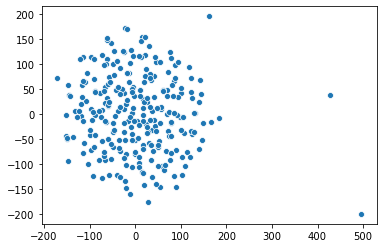

In [13]:
from sklearn.manifold import TSNE
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
model = TSNE(n_components=3, random_state=0)
X_embedded = model.fit_transform(title_apple_vec)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1])

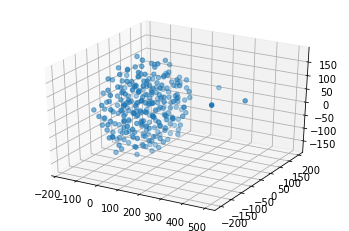

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*zip(*X_embedded))
plt.show()

In [15]:
from pprint import pprint
pprint(texts_title_apple)

[['英特尔', '牙膏', '厂', '抛弃', '苹果', '开发'],
 ['苹果', '多减', '空增'],
 ['推', '升级', '版本', '发布', '一月', '更新', '四次', '苹果', '踏上', '补', '不归路'],
 ['苹果', '华为', '阿里', '参加', '第六届', '世界', '互联网', '大会'],
 ['苹果', '首次', '发布', '安装', '量', '超', '半数', '用户', '更新'],
 ['销量', '好于', '预期', '服务', '领域', '发力', '苹果', '重返', '全球', '市值', '第一'],
 ['苹果', '研发', '智能', '戒指', '中国', '穿戴', '设备', '出货量', '分析'],
 ['雀巢', '苹果', '共振', '阿里', '打假', '联盟', '聚集', '全球', '品牌', '联手', '打假'],
 ['苹果', '概念股', '稳步', '走高'],
 ['苹果', '低头', '系列', '代表', '苹果', '妥协'],
 ['苹果', '月底', '发布', '新', '售价', '超'],
 ['苹果', '旧款', '升级', '系统', '故障'],
 ['苹果', '屏幕', '供应商', '预计', '年', '智能手机', '大行其道'],
 ['分析师', '苹果', '明年', '推出', '四款'],
 ['苹果', '美国', '官网', '清仓', '元起'],
 ['苹果', '概念股', '开盘', '快速', '走高'],
 ['苹果', '印度', '组装', '开售', '售价', '约'],
 ['降临', '代工厂', '苹果', '生产', '英寸'],
 ['苹果', '租', '伦敦', '建筑', '平方英尺', '空间', '做', '办公室'],
 ['苹果', '清仓', '系列', '明年', '发布', '新机', '做'],
 ['苹果', '困局', '股价', '飙涨', '背后', '转型', '难题'],
 ['苹果', '缩短', '付款', '期限', '屏幕', '制造商', '改善', '现金流', '状况'],
 ['三星', '

In [30]:
import pickle
with open('title_apple_vec.np', 'wb') as f:
    pickle.dump(title_apple_vec, f)

In [31]:
def company2vec(name):
    doc_title = "./data/company/title_" + name + ".txt"
    corp_title = preprocess_data(doc_title, stopwords)
    texts_title = cut_low_freq_word(corp_title, 0)
    title_tfidf = tfidf.transform(texts_title).toarray()
    title_weight = get_tfidf_weight(title_tfidf, texts_title)
    title_w2v = get_w2v_matrix(texts_title)
    title_vec = get_sentence_embedding(title_w2v, title_weight)
    with open('title_'+ name +'_vec.np', 'wb') as f:
        pickle.dump(title_vec, f)   

In [36]:
company2vec("zzd")

  0%|          | 0/28 [00:00<?, ?it/s]<ipython-input-9-86b5834f3e10>:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sentence_w2v.append(model_w2v[word])
100%|██████████| 28/28 [00:00<00:00, 10339.89it/s]

getting tfidf...
getting word2vec matrix...
getting sentence embedding...
